## Imports and setup

In [1]:
import os

import numpy as np

from sklearn import datasets as skdatasets

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

from matplotlib import pyplot as plt

from tqdm.notebook import tqdm

from datasets import get_dataset
from models import NCSN
from losses import NCSNLoss, GaussianPerturbation
from train import Trainer
from samplers import AnnealedLangevinDynamics

from utils import get_torch_device

In [2]:
device = get_torch_device()
print(device)

mps


## Toy example

In [3]:
def normalize(ds, scaling_factor=2.0):
    return (ds - ds.mean()) / ds.std() * scaling_factor

def sample_checkerboard(n):
    # https://github.com/ghliu/SB-FBSDE/blob/main/data.py
    n_points = 3 * n
    n_classes = 2
    freq = 5
    x = np.random.uniform(
        -(freq // 2) * np.pi, (freq // 2) * np.pi, size=(n_points, n_classes)
    )
    mask = np.logical_or(
        np.logical_and(np.sin(x[:, 0]) > 0.0, np.sin(x[:, 1]) > 0.0),
        np.logical_and(np.sin(x[:, 0]) < 0.0, np.sin(x[:, 1]) < 0.0),
    )
    y = np.eye(n_classes)[1 * mask]
    x0 = x[:, 0] * y[:, 0]
    x1 = x[:, 1] * y[:, 0]
    sample = np.concatenate([x0[..., None], x1[..., None]], axis=-1)
    sqr = np.sum(np.square(sample), axis=-1)
    idxs = np.where(sqr == 0)
    sample = np.delete(sample, idxs, axis=0)

    return sample

def load_twodim(num_samples: int, dataset: str, dimension: int = 2):
    if dataset == "gaussian_centered":
        sample = np.random.normal(size=(num_samples, dimension))
        sample = sample*2 - 1

    if dataset == "gaussian_shift":
        sample = np.random.normal(size=(num_samples, dimension))
        sample = sample + 1.5

    if dataset == "circle":
        X, y = skdatasets.make_circles(
            n_samples=num_samples, noise=0.0, random_state=None, factor=0.5
        )
        sample = X * 4

    if dataset == "scurve":
        X, y = skdatasets.make_s_curve(
            n_samples=num_samples, noise=0.0, random_state=None
        )
        sample = normalize(X[:, [0, 2]])

    if dataset == "moon":
        X, y = skdatasets.make_moons(n_samples=num_samples, noise=0.0, random_state=None)
        sample = normalize(X)

    if dataset == "swiss_roll":
        X, y = skdatasets.make_swiss_roll(
            n_samples=num_samples, noise=0.0, random_state=None, hole=True
        )
        sample = normalize(X[:, [0, 2]])

    if dataset == "checkerboard":
        sample = normalize(sample_checkerboard(num_samples))

    return torch.tensor(sample).float()


class TwoDimDataClass(Dataset):
    def __init__(self, dataset_type: str, N: int, batch_size: int, dimension=2):

        self.X = load_twodim(N, dataset_type, dimension=dimension)
        self.name = dataset_type
        self.batch_size = batch_size
        self.dimension = 2

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx]

    def get_dataloader(self, shuffle=True):
        return DataLoader(
            self,
            batch_size=self.batch_size,
            shuffle=shuffle,
            pin_memory=True,
        )

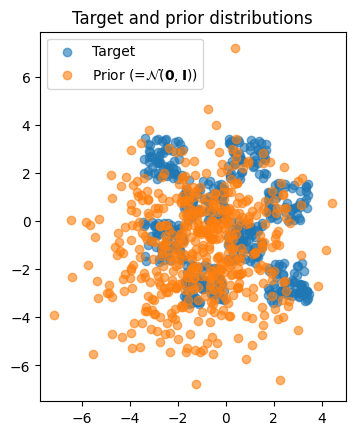

In [4]:
target_ds = TwoDimDataClass(dataset_type='checkerboard',
                            N=int(1e6),
                            batch_size=256)

prior_ds = TwoDimDataClass(dataset_type='gaussian_centered',
                           N=int(1e6),
                           batch_size=256)

train_loader = DataLoader(target_ds, batch_size=8196 * 2)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(target_ds[:500][:, 0], target_ds[:500][:, 1], alpha=0.6)
ax.scatter(prior_ds[:500][:, 0], prior_ds[:500][:, 1], alpha=0.6)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')
strtitle = "Target and prior distributions"
ax.set_title(strtitle)
ax.legend(['Target', r'Prior (=$\mathcal{N}(\mathbf{0}, \mathbf{I})$)'])

In [5]:
class ToyScoreNet(nn.Module):
  def __init__(self, n_steps):
    super().__init__()
    self.linear_model1 = nn.Sequential(
        nn.Linear(2, 256),
        nn.Dropout(0.3),
        nn.GELU()
    )
    self.embedding_layer = nn.Embedding(n_steps, 256)
    self.linear_model2 = nn.Sequential(
        nn.Linear(256, 512),
        nn.Dropout(0.3),
        nn.GELU(),
        nn.Linear(512, 512),
        nn.Dropout(0.3),
        nn.GELU(),
        nn.Linear(512, 2),
    )

  def forward(self, x, idx):
    out = self.linear_model1(x)
    embed = self.embedding_layer(idx)
    return self.linear_model2(out + embed)

In [6]:
L = 12
sigmas = torch.exp(torch.linspace(torch.log(torch.tensor(1e1)), torch.log(torch.tensor(1e-3)), L)).to(device)

model = ToyScoreNet(L)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

perturbation = GaussianPerturbation()
loss_fn = NCSNLoss(perturbation, sigmas, coeff_func=lambda s: s**2)

trainer = Trainer(train_loader, model, device)
sampler = AnnealedLangevinDynamics(model, sigmas, device)

In [7]:
if os.path.exists("model_toy.pth"):
    model.load_state_dict(torch.load("model_toy.pth"))
else:
    trainer.train(loss_fn, optimizer, epochs=120, verbose=True)
    torch.save(model.state_dict(), "model_toy.pth")

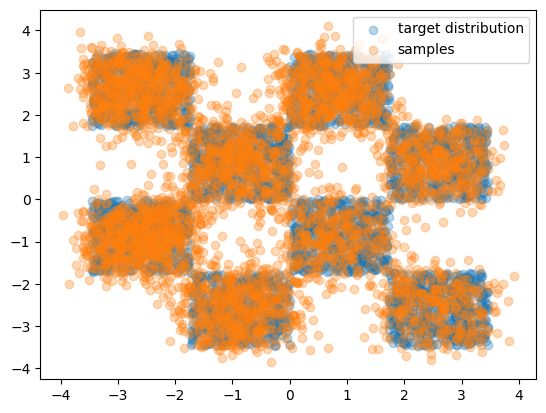

In [8]:
n_samples = 2 ** 12
shape = (n_samples, 2)
gen = sampler.sample(shape, epsilon=1e-6).cpu().numpy()

fig, ax = plt.subplots(1,1)
ax.scatter(target_ds[:n_samples][:,0], target_ds[:n_samples][:,1], alpha=0.3, label="target distribution")
ax.scatter(gen[:,0], gen[:,1], alpha=0.3, label="samples")
ax.legend()
plt.show()

## Annealed MNIST

In [9]:
sigma0 = 1
sigmaL = 0.01
L = 10

sigmas = torch.exp(torch.linspace(np.log(sigma0), np.log(sigmaL), L)).to(device)
print(sigmas)

tensor([1.0000, 0.5995, 0.3594, 0.2154, 0.1292, 0.0774, 0.0464, 0.0278, 0.0167,
        0.0100], device='mps:0')


In [10]:
B = 128

train_loader, test_loader = get_dataset("mnist", batch_size=B, num_workers=2, pin_memory=False)
shape = (28, 28, 1)

In [11]:
model = NCSN(shape, L, filters=64)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(summary(model, [(1, *shape[::-1]), (1,)], dtypes=[torch.float, torch.long]))

Layer (type:depth-idx)                                                           Output Shape              Param #
NCSN                                                                             [1, 1, 28, 28]            --
├─Conv2d: 1-1                                                                    [1, 64, 28, 28]           640
├─ConditionalSequential: 1-2                                                     [1, 128, 14, 14]          2,075,584
│    └─ConditionalResidualBlock: 2-1                                             [1, 64, 28, 28]           75,776
│    │    └─ConditionalInstanceNorm2dPlus: 3-1                                   [1, 64, 28, 28]           1,920
├─ConditionalSequential: 1-122                                                   --                        (recursive)
│    └─ELU: 2-2                                                                  [1, 64, 28, 28]           --
├─ConditionalSequential: 1-34                                                    --        

In [12]:
perturbation = GaussianPerturbation()
loss_fn = NCSNLoss(perturbation, sigmas, coeff_func=lambda s: s**2)

In [13]:
if os.path.exists("model_mnist.pth"):
    model.load_state_dict(torch.load("model_mnist.pth"))

In [14]:
trainer = Trainer(train_loader, model, device)
sampler = AnnealedLangevinDynamics(model, sigmas, device)

In [15]:
def sample_img(sampler, arg):
    if isinstance(arg, (list, tuple, torch.Size)):
        img = sampler.sample(shape[::-1], epsilon=2e-5).squeeze(0).permute(1, 2, 0).cpu().numpy()
    else:
        img = sampler.sample(arg, epsilon=2e-5).squeeze(0).permute(1, 2, 0).cpu().numpy()
    
    return img

In [16]:
# for e in range(0):
#     trainer.train(loss_fn, optimizer, epochs=4, verbose=True, reset=False)
    
#     img = sample_img(sampler, shape)
#     plt.imshow(img, cmap="gray")
#     plt.show()
# torch.save(model.state_dict(), "model_mnist.pth")

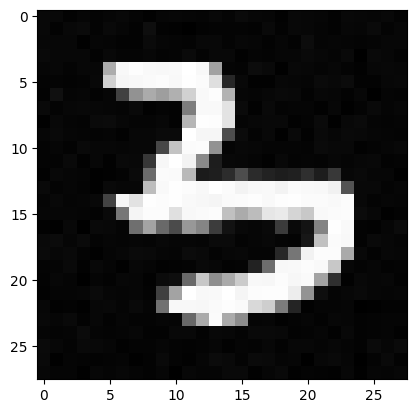

In [17]:
img = sample_img(sampler, shape)
plt.imshow(img, cmap="gray")
plt.show()